# Arduino Uno DAQ (Serial -> Python)

This notebook is focused on **single channel data acquisition** (DAQ) from an Arduino connected over USB Serial. 

**Workflow:**
1. Overview
2. Hardware setup + wiring / channel map
3. Install + imports
4. DAQ Config
5. Acquire
6. Live view
7. Save data + metadata + Post plot



## 2. Hardware setup + wiring / channel map

**Arduino sketch expectations**
- The Arduino should stream lines like: `arduino_us,raw` then `1234567,512`
- `arduino_us` = `micros()` on the Arduino
- `raw` = ADC count (≤1023 on Uno) from one analog input
- A sample Arduino Sketch is provided here: [https://github.com/mrsoltys/GEEN3853-Data-Acquisition/blob/main/Arduino_Uno_to_Python_DAQ/Arduino_Uno_to_Python_DAQ.ino](https://github.com/mrsoltys/GEEN3853-Data-Acquisition/blob/main/Arduino_Uno_to_Python_DAQ/Arduino_Uno_to_Python_DAQ.ino)

**Channel map**
- `A0`  `ch0_V` (converted to volts in Python)

**Wiring reminder**
- Signal → A0
- Ground → GND
- Keep voltages within the Arduino ADC range (typically ≤5V unless you know what you're doing).


## 3. Install + imports

If you're using conda, install once:

```bash
conda install -c conda-forge ipympl pyserial pandas matplotlib numpy
```

Then restart the kernel.

In [2]:
# Interactive plotting backend (recommended for live view)
%matplotlib widget

import time
from datetime import datetime
from collections import deque
import threading

import numpy as np
import pandas as pd

import serial
import serial.tools.list_ports

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## 4. DAQ Config
# List available serial ports
Unplug/replug the Arduino and re-run this cell if you're unsure which port is your Arduino.

In [3]:
ports = list(serial.tools.list_ports.comports())

if not ports:
    print("No serial ports found. Plug in the Arduino and try again.")
else:
    print("Available serial ports:")
    for p in ports:
        print(f"{p.description}:  {p.device}")

Available serial ports:
n/a:  /dev/cu.debug-console
n/a:  /dev/cu.Bluetooth-Incoming-Port
IOUSBHostDevice:  /dev/cu.usbmodem101


# Connect to the Arduino
Edit `PORT` to match your Arduino port from the list above.

- macOS often looks like: `/dev/cu.usbmodemXXXX`
- Windows often looks like: `COM5`

Also check that `BAUD` matches the baud rate specified in `Serial.begin()` in your Arduino sketch

Finally, set `sample_rate_hz` to  match your Arduino Sketch. Note: This python script does not control the sampling frequency of the Arduino, that is done in Arduino. Give an approprate `duration_s` for how long you'd like to aquire data.


In [4]:
# --- Arduino / ADC config ---
PORT = '/dev/cu.usbmodem101'   # Must match your Serial Port listed above (e.g., 'COM5' on Windows)
BAUD = 115200                   # must match Serial.begin(...) in your sketch
sample_rate_hz = 250.0          # target rate. Must match rate in Arduino Sketch
duration_s = 15.0               # How Long to gather data [seconds]
n_samples = int(round(sample_rate_hz * duration_s))
print(f'n_samples = {n_samples} (target)')

# --- Core DAQ config  ---
channels = ['ch0_V']
units = {'ch0_V': 'V'}
v_ref = 5.0                     # ADC reference voltage (V) 5V on Uno. 3.3V on Teensy4.1
adc_max = 1023                  # 10-bit ADC on Uno (2^10-1). 12 Bit on Teensy (2^12-1)

# --- Live View ----
live_view = True              # Set to True if you want a live plot as you record data
chunk_samples = 50            # UI update / buffer chunk size (not a hardware setting)
plot_window_s = 5.0           # seconds shown in the live view window

# Connect (opening the port typically resets the Arduino)
ser = serial.Serial(PORT, BAUD, timeout=1)
print(f"Connected to {PORT} at {BAUD} baud")

n_samples = 3750 (target)
Connected to /dev/cu.usbmodem101 at 115200 baud


## 5. Acquire
This section acquires **exactly** `n_samples` and stores results in memory.

Live plot will show below if `live_view = True`

Data acquisition started...


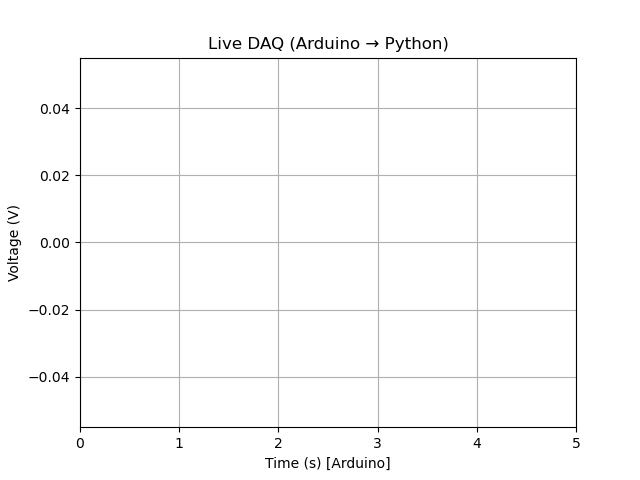

Waiting for data collection to complete...
✓ Thread finished
Collected 7655 samples (time-based run: 15.0 s). Target n_samples config: 3750
   time_s     ch0_V  arduino_us
0   0.000  4.736070          76
1   0.672  4.736070      672076
2   0.674  4.740958      674076
3   0.676  4.740958      676076
4   0.678  4.740958      678076
✓ DataFrame built with 7655 samples


In [5]:
# =========================
# Arduino DAQ: Acquire + Live View (robust single-cell)
# =========================

# --- Close old figures to avoid "plot spam" from prior runs ---
plt.close('all')

# --- CLEANUP from previous runs (stop old thread cleanly) ---
try:
    if 'stop_flag' in globals():
        stop_flag = True
    if 'thread' in globals() and thread is not None and thread.is_alive():
        print("Stopping previous thread...")
        stop_flag = True
        thread.join(timeout=2.0)
except Exception:
    pass

# --- Initialize fresh state for THIS run ---
log_rows = []
stop_flag = False
t0_pc = time.time()

# Plot buffers sized from plot_window_s + sample_rate_hz (safe minimum)
N = int(max(50, round(plot_window_s * sample_rate_hz)))
tbuf = deque(maxlen=N)
vbuf = deque(maxlen=N)

def parse_line(line: str):
    """Expected Arduino format: us,raw OR arduino_us,raw."""
    s = line.strip()
    if not s:
        return None
    sl = s.lower()
    if sl.startswith("us") or sl.startswith("arduino_us"):
        return None
    parts = s.split(",")
    if len(parts) != 2:
        return None
    try:
        return int(parts[0].strip()), int(parts[1].strip())
    except ValueError:
        return None

# --- Reader thread: time-based stop, per execution ---
def reader():
    global stop_flag, log_rows

    # Aggressive flush so each run starts "fresh"
    ser.reset_input_buffer()
    time.sleep(0.05)
    ser.reset_input_buffer()

    first_arduino_us = None
    t_start = None

    while not stop_flag:
        line = ser.readline().decode("utf-8", errors="ignore")
        parsed = parse_line(line)
        if parsed is None:
            continue

        arduino_us, raw = parsed

        # Start timing on the first valid sample of THIS run
        if first_arduino_us is None:
            first_arduino_us = arduino_us
            t_start = time.time()

        # Stop after duration_s seconds from THIS run’s first sample
        if (time.time() - t_start) >= duration_s:
            stop_flag = True
            break

        t_s = (arduino_us - first_arduino_us) / 1_000_000.0
        volts = (raw / adc_max) * v_ref

        tbuf.append(t_s)
        vbuf.append(volts)

        log_rows.append({
            "pc_time_s": time.time() - t0_pc,
            "arduino_us": arduino_us,
            "raw": raw,
            "ch0_V": volts,
        })

    stop_flag = True

# --- Start reader thread (non-daemon so we can control stop/join reliably) ---
thread = threading.Thread(target=reader, daemon=False)
thread.start()
print("Data acquisition started...")

# --- Live view (optional) ---
ani = None
fig = None

if live_view:
    fig, ax = plt.subplots()
    (line_plot,) = ax.plot([], [])
    ax.set_xlabel("Time (s) [Arduino]")
    ax.set_ylabel("Voltage (V)")
    ax.grid(True)
    ax.set_title("Live DAQ (Arduino → Python)")

    # Set fixed x-window to last plot_window_s seconds (nicer live view)
    ax.set_xlim(0, plot_window_s)

    def update(_frame):
        # Only draw if we have data
        if len(tbuf) >= 2:
            x = list(tbuf)
            y = list(vbuf)
            line_plot.set_data(x, y)

            # Keep the x-axis as a scrolling window
            x_max = x[-1]
            x_min = max(0.0, x_max - plot_window_s)
            ax.set_xlim(x_min, x_max if x_max > plot_window_s else plot_window_s)

            # Light autoscale for y only (fast)
            y_min, y_max = min(y), max(y)
            pad = 0.05 * (y_max - y_min + 1e-12)
            ax.set_ylim(y_min - pad, y_max + pad)

        # Stop animation when acquisition ends
        if stop_flag and ani is not None:
            try:
                ani.event_source.stop()
            except Exception:
                pass

        return (line_plot,)

    # Update rate tied to chunk_samples target, but clamp so it stays responsive
    update_interval_ms = int(max(20, min(200, round(1000 * chunk_samples / max(sample_rate_hz, 1e-9)))))

    ani = FuncAnimation(
        fig,
        update,
        interval=update_interval_ms,
        blit=False,
        cache_frame_data=False
    )

    plt.show()

    # IMPORTANT: do NOT thread.join() here; keep UI alive.
    # Use flush_events + sleep (works better than plt.pause with ipympl).
    print("Waiting for data collection to complete...")
    while thread.is_alive():
        try:
            fig.canvas.flush_events()
        except Exception:
            pass
        time.sleep(0.05)

else:
    print(f"Collecting for {duration_s} seconds (no live plot)...")
    thread.join()

# Final join (should be immediate)
thread.join(timeout=1.0)

print("✓ Thread finished")
print(f"Collected {len(log_rows)} samples (time-based run: {duration_s} s). Target n_samples config: {n_samples}")

# --- Build DataFrame ---
if len(log_rows) > 0:
    arduino_us_arr = np.array([r["arduino_us"] for r in log_rows], dtype=np.int64)
    v_arr = np.array([r["ch0_V"] for r in log_rows], dtype=np.float64)
    time_s = (arduino_us_arr - arduino_us_arr[0]) * 1e-6

    df = pd.DataFrame({
        "time_s": time_s,
        "ch0_V": v_arr,
        "arduino_us": arduino_us_arr,
    })

    print(df.head())
    print(f"✓ DataFrame built with {len(df)} samples")
else:
    print("⚠ No data collected!")
    df = pd.DataFrame()



## 6. Save data + metadata + post plot
This section exports a CSV (Excel-friendly)

In [ ]:
# Compute achieved / effective sample rate from time stamps
if len(df) > 1:
    dt = np.diff(df['time_s'].values)
    effective_sample_rate_hz = 1.0 / np.median(dt)
else:
    effective_sample_rate_hz = float('nan')

run_id = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = f'arduino_daq_{run_id}.csv'

# Save single CSV with metadata header
with open(csv_path, 'w') as f:
    # Write metadata as commented lines at the top
    f.write(f"# Arduino DAQ Data\n")
    f.write(f"# Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"# Device: Arduino Uno\n")
    f.write(f"# Port: {PORT}\n")
    f.write(f"# Baud Rate: {BAUD}\n")
    f.write(f"# Requested Sample Rate: {sample_rate_hz} Hz\n")
    f.write(f"# Effective Sample Rate: {effective_sample_rate_hz:.2f} Hz\n")
    f.write(f"# Duration: {duration_s} s\n")
    f.write(f"# Number of Samples: {len(df)}\n")
    f.write(f"# ADC Reference Voltage: {v_ref} V\n")
    f.write(f"# ADC Max Value: {adc_max}\n")
    f.write(f"# Channels: {', '.join(channels)}\n")
    f.write(f"#\n")
    
    # Write the actual data (pandas will append to the file)
    df[['time_s', 'ch0_V']].to_csv(f, index=False)

print(f'Saved data + metadata to: {csv_path}')

# Post plot (static)
plt.figure()
plt.plot(df['time_s'], df['ch0_V'])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title(f'Arduino Uno | {len(df)} samples | effective ~ {effective_sample_rate_hz:.1f} Hz')
plt.grid(True)
plt.show()

# Clean up
try:
    ser.close()
    print('Serial port closed.')
except Exception as e:
    print('Warning: could not close serial port:', e)

In [ ]:
df

In [ ]:
df